In [1]:
import torch
from pykeops.torch import LazyTensor
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
def rbf(X, sigma, device):
    x1_lazy = LazyTensor(X[:, None, :])
    x2_lazy = LazyTensor(X[None, :, :])
    D = ((x1_lazy - x2_lazy) ** 2).sum(dim=2)
    K = (-D / (2 * sigma ** 2)).exp()

    return K @ torch.eye(X.shape[0], device=device)

In [3]:
torch.manual_seed(0)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# m = 10000
# d = 20
sigma = 0.1
delta = 0.01
lambd = 1.0
# X = torch.randn(m, d, device=device)

# Load data and standardize
X, y = load_svmlight_file("../data/cod-rna")
X = X.toarray()
X = X[:5000, :] # Subsample
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = torch.tensor(X, device=device, dtype=torch.float32)

kernel_fn = lambda Y: rbf(Y, sigma, device)

In [6]:
def rrls_nystrom(X, kernel_fn, lambd, delta, device):
    m, _ = X.shape
    print(f"m ub = {192 * torch.log(1/delta)}")
    if m <= 192 * torch.log(1 / delta):
        return torch.eye(m, device=device)
    
    # Sample rows of X independently, each with probability 1/2
    S_bar = torch.bernoulli(0.5 * torch.ones(m, device=device)).bool()
    S_bar_mat = torch.zeros(m, torch.sum(S_bar), device=device)
    S_bar_mat[S_bar, torch.arange(torch.sum(S_bar))] = 1
    S_til = rrls_nystrom(X[S_bar], kernel_fn, lambd, delta / 3, device)
    print(f"S_bar_mat.shape = {S_bar_mat.shape}")
    print(f"S_til.shape = {S_til.shape}")
    S_hat = S_bar_mat @ S_til # TODO(pratik): Try making this more efficient in the future

    # Compute approximate leverage scores
    K = kernel_fn(X)
    S_hatT_K = S_hat.T @ K
    C = S_hatT_K @ S_hat # TODO(pratik): optimize this -- think of it as taking the block kernel followed by column/row scaling
    C.diagonal().add_(lambd)
    L = torch.linalg.cholesky(C)
    nys_sqrt = torch.linalg.solve_triangular(L, S_hatT_K, upper=False)

    l_tilde = 3/(2 * lambd) * (torch.diagonal(K) - torch.sum(nys_sqrt ** 2, dim=0))
    print(f"min of unscaled leverage scores = {torch.min(torch.diagonal(K) - torch.sum(nys_sqrt ** 2, dim=0))}")
    print(f"max of unscaled leverage scores = {torch.max(torch.diagonal(K) - torch.sum(nys_sqrt ** 2, dim=0))}")
    adj_factor = torch.log(torch.sum(l_tilde) / delta)
    print(
        f"min of adjusted leverage scores = {torch.min(adj_factor * l_tilde)}")
    p = torch.minimum(torch.ones(m, device=device), adj_factor * l_tilde)
    # print(f"min of adjusted leverage scores = {torch.min(16 * adj_factor * l_tilde)}")
    # p = torch.minimum(torch.ones(m, device=device), 16 * adj_factor * l_tilde)

    # Form the new sampling matrix
    sampling_vector = torch.bernoulli(p)
    # Find indices of sampling_vector that equal 1
    sampling_indices = torch.nonzero(sampling_vector == 1).squeeze()
    num_columns = sampling_indices.shape[0]
    S = torch.zeros(m, num_columns, device=device)
    S[sampling_indices, torch.arange(num_columns)] = 1 / torch.sqrt(p[sampling_indices])
    return S

In [7]:
S = rrls_nystrom(X, kernel_fn, lambd, torch.tensor([delta], device=device), device)

m ub = tensor([884.1927], device='cuda:0')
m ub = tensor([1095.1262], device='cuda:0')
m ub = tensor([1306.0598], device='cuda:0')
S_bar_mat.shape = torch.Size([2514, 1300])
S_til.shape = torch.Size([1300, 1300])
min of unscaled leverage scores = 0.24694347381591797
max of unscaled leverage scores = 1.0
min of adjusted leverage scores = 5.045075416564941
S_bar_mat.shape = torch.Size([5000, 2514])
S_til.shape = torch.Size([2514, 2514])
min of unscaled leverage scores = 0.19708997011184692
max of unscaled leverage scores = 1.0
min of adjusted leverage scores = 3.9026079177856445


In [8]:
S

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0')

In [9]:
S.shape

torch.Size([5000, 5000])

### Compute exact leverage scores

In [10]:
K = rbf(X, sigma, device)
L = torch.linalg.cholesky(K + lambd * torch.eye(X.shape[0], device=device))

# L^-T L^-1 K
L_inv_K = torch.linalg.solve_triangular(L, K, upper=False)
LT_inv_L_inv_K = torch.linalg.solve_triangular(L.T, L_inv_K, upper=True)

leverage_scores = torch.diagonal(LT_inv_L_inv_K)

(array([7.000e+00, 0.000e+00, 6.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        4.000e+00, 0.000e+00, 1.000e+01, 1.000e+00, 5.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 5.000e+00, 7.000e+00, 3.000e+00, 1.000e+00, 9.000e+00,
        3.000e+00, 4.000e+00, 4.000e+00, 6.000e+00, 6.000e+00, 4.000e+00,
        1.000e+00, 6.000e+00, 2.000e+00, 6.000e+00, 4.000e+00, 3.000e+00,
        4.000e+00, 3.000e+00, 8.000e+00, 6.000e+00, 4.000e+00, 4.000e+00,
        5.000e+00, 1.100e+01, 2.400e+01, 1.110e+02, 7.000e+00, 1.500e+01,
        3.400e+01, 7.000e+00, 2.000e+00, 5.500e+01, 3.000e+00, 1.200e+01,
        5.000e+00, 4.100e+01, 3.000e+00, 1.000e+00, 7.000e+00, 5.000e+00,
        3.600e+01, 3.000e+00, 2.000e+00, 4.000e+00, 1.600e+01, 3.800e+01,
        1.200e+01, 8.000e+00, 3.000e+0

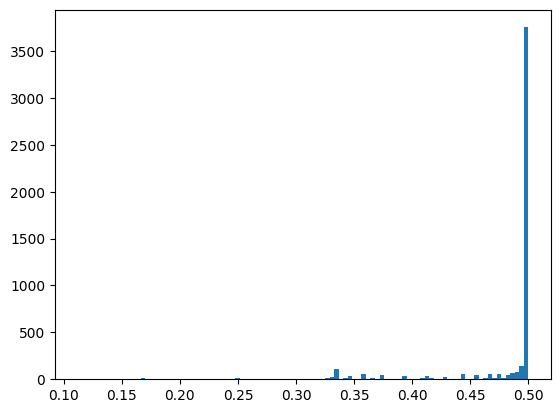

In [11]:
plt.hist(leverage_scores.cpu().numpy(), bins=100)